# Dependencies

In [123]:
import torch
import functools 

from osmnx_utils import gps_to_meters

# Overview
The InvSqLoss class is used to train a neural network predicting values at gps coordinates with labels available at only a few coordinates. We are reasoning that predictions located closely to labels should have be close in value to those labels; specifically, we are assuming that the confidence in the similarity to those labels decreases with the distance squared and drops off completely after a given distance.

In [124]:
def dists(x: torch.tensor, y: torch.tensor, /) -> torch.tensor: 
    """
    Compute pair-wise distances between two arrays of gps coordinates (longitude, latitude)
    in meters. 
    """
    # Choose the scale at the average latitude 
    scale = gps_to_meters(x[:, 1].mean())
    return torch.linalg.norm(
        (x - y.view(-1, 1, 2)) * torch.tensor(scale), 
        axis=-1, 
    )


def dists_min(fro: torch.tensor, to: torch.tensor) -> torch.tensor:
    """
    Compute minimum distances from all elements of fro to any element of to.
    """
    return dists(fro, to).min(axis=0)[0]

In [214]:
class InvSqLoss:
    """
    Computes the inverse squared loss between ouputs and labels based ont the gps coordinates of the 
    ouputs and labels. Additionally radius (in meters) can be given to only include in the calculation 
    ouputs which are within radius distance away from a label. 
    """
    def __init__(self, outputs_gps: torch.Tensor, labels_gps: torch.Tensor, radius: float = None):
        self.dists = dists_min(fro=outputs_gps, to=labels_gps)
        self.radius = radius
        self.weights = torch.pow(self.dists, -2)
        self.dists = self.dists[self.indices_in_radius]
        self.weights = self.weights[self.indices_in_radius]

    @functools.cached_property
    def indices_in_radius(self) -> torch.Tensor:
        """
        Returns indices of elements in self.dists which are no greater than self.radius.
        """
        return torch.ones(self.dists.shape, dtype=torch.long) if self.radius is None \
    else (self.dists <= self.radius).nonzero().type(torch.long).squeeze()
    
        
    def loss(self, pred: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Computes the inverse-squared loss based on outputs within radius distance of any label. 
        This is essentially MSE weighted by inverse distance squared. 
        """
        return (
            (pred[self.indices_in_radius] - labels).pow(2) * self.weights
        ).mean()
    
    def __call__(self, *args, **kwargs):
        """
        For convenience, the InvSqLoss object may be called to invoke the loss method. 
        """
        return self.loss(*args, **kwargs)

# Example
We will create three sets of concentric washers, where each washer contains predictions of different values. We will see that the further away from the label we are, the lower the influence of the predictides values; however, if the values are very large, they can still sway the loss, even if far away. 

In [126]:
import pandas as pd

from dataset import Dataset 
from matplotlib import pyplot as plt

In [207]:
# Inner washer with predicted value 1 
n1 = 100
t1 = torch.rand(n1).view(-1, 1) * 2 * torch.pi
r1 = torch.rand(n1).view(-1, 1)/100
p1 = torch.cat([torch.cos(t1), torch.sin(t1)], dim=1) * r1
v1 = torch.ones(n1) * 1

# Middle washer with predicted value 10
n2 = 500
t2 = torch.rand(n2).view(-1, 1) * 2 * torch.pi
r2 = torch.rand(n2).view(-1, 1)/100 + 0.015
p2 = torch.cat([torch.cos(t2), torch.sin(t2)], dim=1) * r2
v2 = torch.ones(n2) * 10

# Outer washer with predicted value 10000
n3 = 2000
t3 = torch.rand(n3).view(-1, 1) * 2 * torch.pi
r3 = torch.rand(n3).view(-1, 1)/100 + 0.030
p3 = torch.cat([torch.cos(t3), torch.sin(t3)], dim=1) * r3
v3 = torch.ones(n3) * 10000

n_all = n1 + n2 + n3
p_all = torch.cat([p1, p2, p3])
v_all = torch.cat([v1, v2, v3])

# One label in the center 
pl1 = torch.Tensor([[0.0, 0.0]])
vl1 = torch.Tensor([[1.0]])

# Two labels symetrically to the sides of the center
pl2 = torch.Tensor([[-0.015, 0.0], [0.015, 0.0]])
vl2 = torch.Tensor([[1.0], [1.0]])

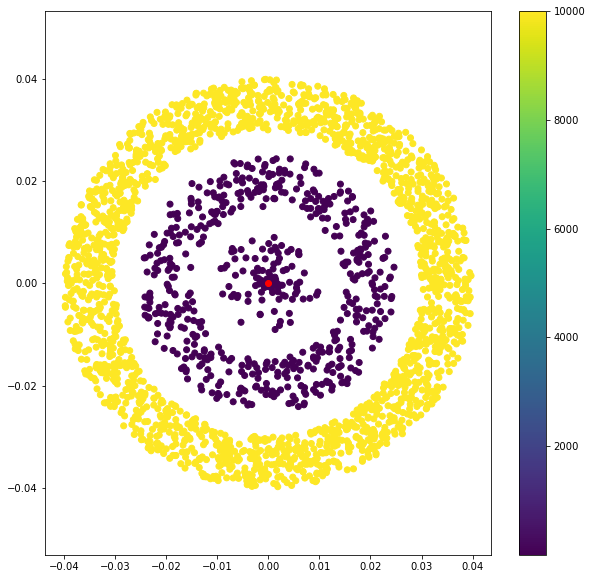

In [211]:
fig, ax = plt.subplots(figsize=(10, 10))

sctr = ax.scatter(*p_all.T, c=v_all)
ax.scatter(*pl1.T, c='r')
plt.colorbar(sctr)
ax.axis('equal');

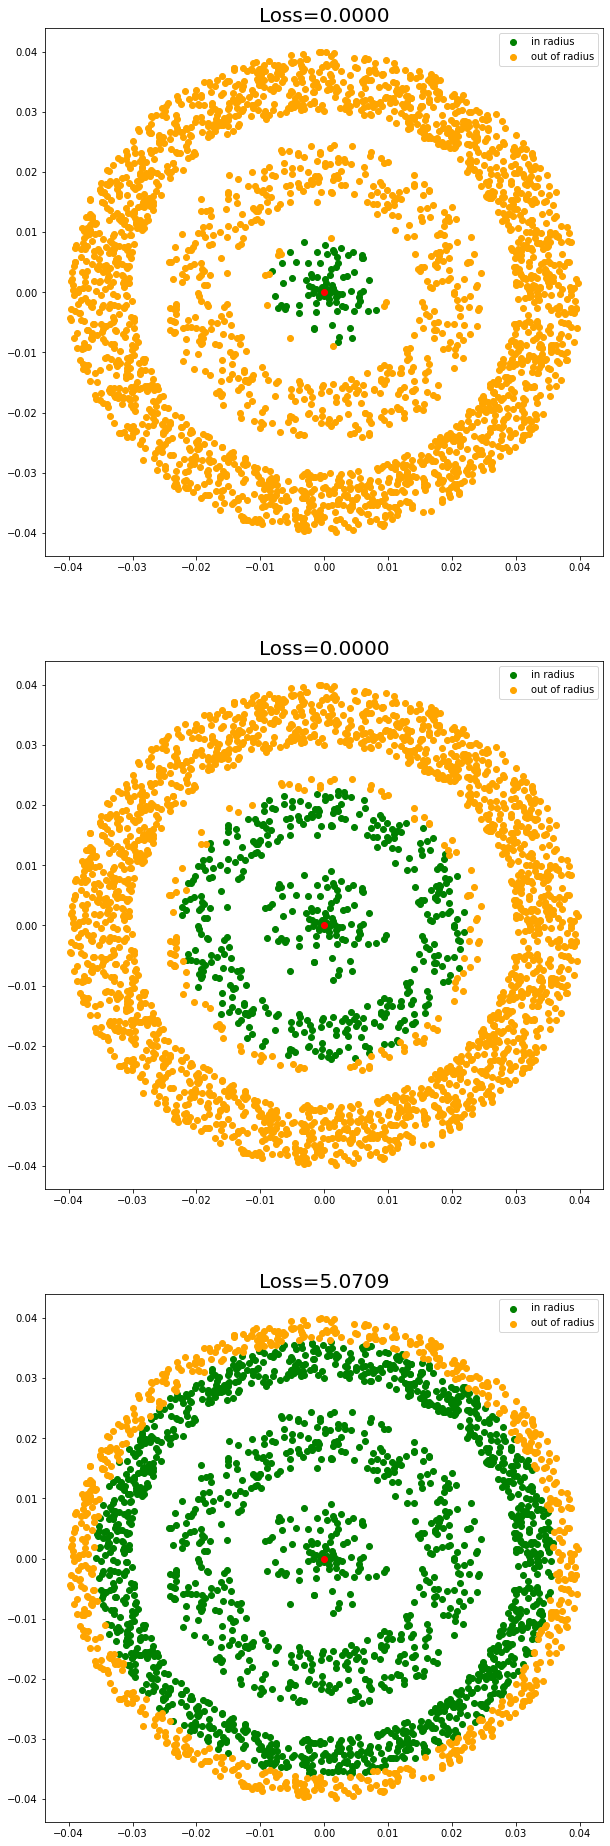

In [212]:
radii = (1000, 2500, 4000)
fig, axes = plt.subplots(len(radii), 1, figsize=(10, 11*len(radii)))

for radius, ax in zip(radii, axes):
    loss = InvSqLoss(outputs_gps=p_all, labels_gps=pl1, radius=radius)
    mask = torch.isin(torch.arange(n_all), loss.indices_in_radius)
    
    ax.scatter(*p_all[mask].T, c='green', label='in radius')
    ax.scatter(*p_all[~mask].T, c='orange', label='out of radius')
    ax.scatter(*pl1.T, c='r')
    ax.legend()
    ax.set_title(f"Loss={loss(v_all, vl1):.4f}", fontsize=20);

InvSqLoss also works with multiple stations. 

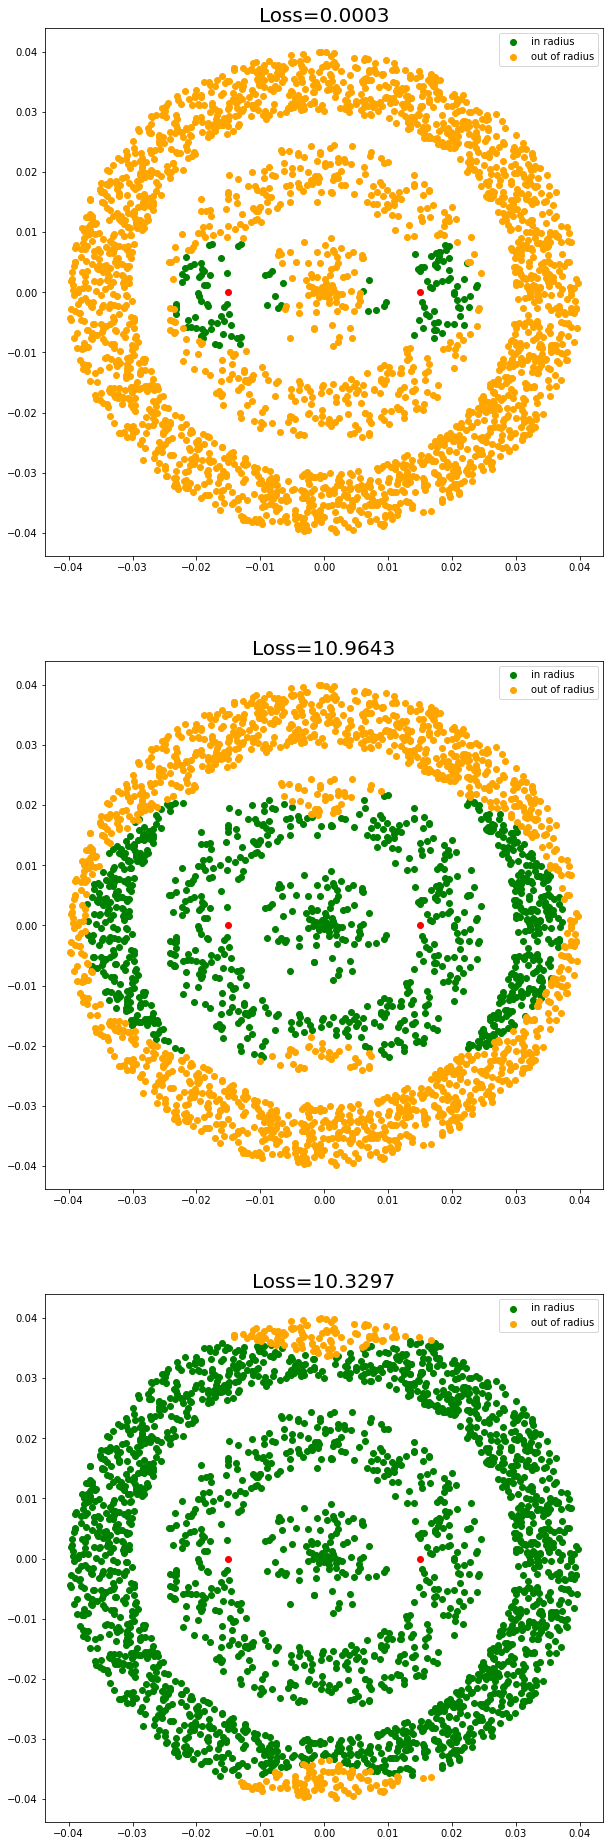

In [213]:
radii = (1000, 2500, 4000)
fig, axes = plt.subplots(len(radii), 1, figsize=(10, 11*len(radii)))

for radius, ax in zip(radii, axes):
    loss = InvSqLoss(outputs_gps=p_all, labels_gps=pl2, radius=radius)
    mask = torch.isin(torch.arange(n_all), loss.indices_in_radius)
    
    ax.scatter(*p_all[mask].T, c='green', label='in radius')
    ax.scatter(*p_all[~mask].T, c='orange', label='out of radius')
    ax.scatter(*pl2.T, c='r')
    ax.legend()
    ax.set_title(f"Loss={loss(v_all, vl2):.4f}", fontsize=20);